# Lab 2: Classification

### Data Preparation

In [56]:
# Import basic packages lik numpy, pandas, math plot and seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE
import warnings
warnings.filterwarnings('ignore') #ignore warning messages 

In [30]:
# import dataset
df = pd.read_csv('https://raw.githubusercontent.com/lijjumathew/MSDS-Machine-Learning-1-Project/master/dataset/Telco-Customer-Churn.csv')

In [31]:
#Ideally SeniorCitizen column should be a factor, so let's convert 1,0 values to Yes,No and later we can label encode all factor columns
df.SeniorCitizen=df.SeniorCitizen.apply(lambda x: 'Yes' if x==1 else 'No')

# Getting rid of unwanted columns like Customer Id.
if 'customerID' in df:
    del df['customerID']

# remove TotalCharges
df=df.drop(['TotalCharges'], axis=1)

# converting TotalCharges object dataset into numeric
#df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors = 'coerce')

# Replacing blank values with nulls.
df=df.replace(r'^\s*$', np.nan, regex=True)

# Total charges has some blank values/missing values and needs to be imputed. Filling the missing values
#df["TotalCharges"].fillna(df["TotalCharges"].mean(), inplace=True)

# Consolidate MultipleLines attribute
df['MultipleLines'] = df['MultipleLines'].replace('No phone service','No')

# Change all values of 'No internet service' to 'No'
df = df.replace('No internet service','No')

# Replace all yes/no values with 1/0
df = df.replace(to_replace=['Yes','No'], value=[1,0])

# Create dummy variables in the entire dataset
df = pd.get_dummies(df)

# check the distribution
df['Churn'].value_counts()/df.shape[0]


0    0.73463
1    0.26537
Name: Churn, dtype: float64

### Data Split

In [32]:
# Separate the churn results from the dataset
y = df['MonthlyCharges'].values
x = df.drop(columns = ['MonthlyCharges'])

# Set features
features = x.columns.values

# Normalize values
scale = MinMaxScaler(feature_range = (0,1))
scale.fit(x)
x = pd.DataFrame(scale.transform(x))
x.columns = features

# Set up train/test split with 80/20 ratio
#x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state = 99)

### Modeling and Evaluation

#### Multiple Linear Regression - Monthly Charges

#### Feature Selection - Filter

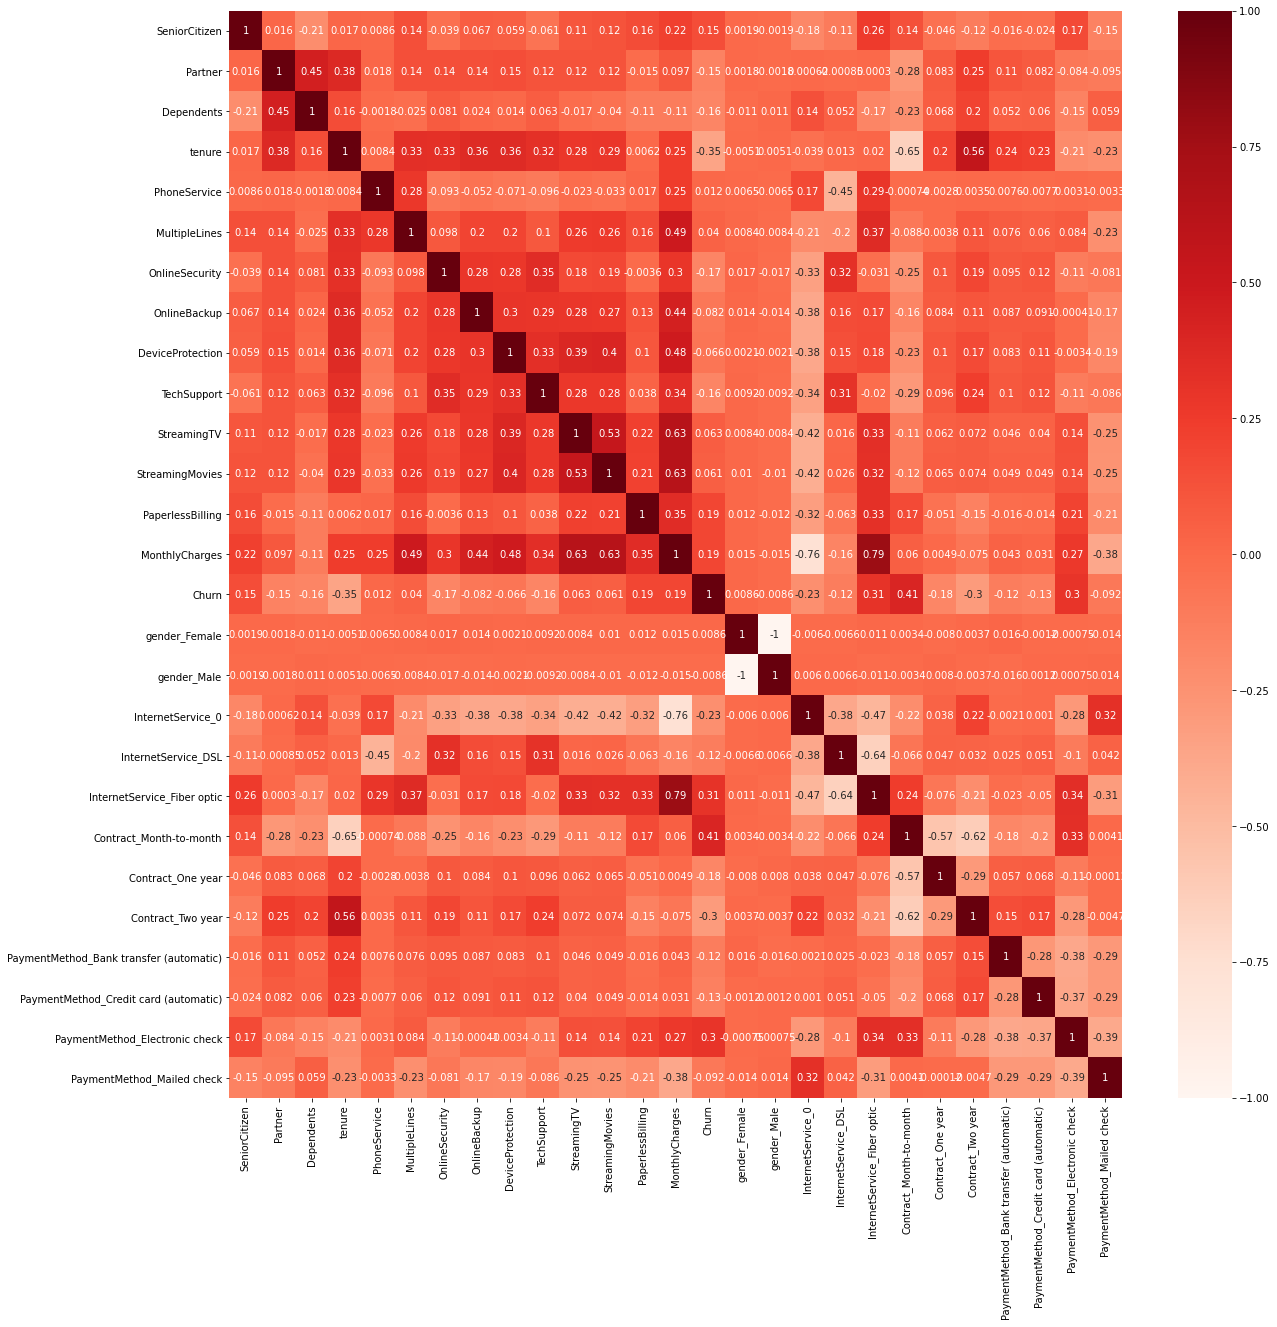

In [33]:
#Using Pearson Correlation
plt.figure(figsize=(20,20))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [37]:
#Correlation with output variable
cor_target = abs(cor["MonthlyCharges"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

StreamingTV                    0.629603
StreamingMovies                0.627429
MonthlyCharges                 1.000000
InternetService_0              0.763557
InternetService_Fiber optic    0.787066
Name: MonthlyCharges, dtype: float64

In [38]:
# looks like all of these are somewhat correlated
print(df[["StreamingTV","StreamingMovies","InternetService_0","InternetService_Fiber optic"]].corr())

                             StreamingTV  StreamingMovies  InternetService_0  \
StreamingTV                     1.000000         0.533094          -0.415552   
StreamingMovies                 0.533094         1.000000          -0.418675   
InternetService_0              -0.415552        -0.418675           1.000000   
InternetService_Fiber optic     0.329349         0.322923          -0.465793   

                             InternetService_Fiber optic  
StreamingTV                                     0.329349  
StreamingMovies                                 0.322923  
InternetService_0                              -0.465793  
InternetService_Fiber optic                     1.000000  


#### Feature Selection - Wrapper

In [40]:
#Adding constant column of ones, mandatory for sm.OLS model
x_1 = sm.add_constant(x)
#Fitting sm.OLS model
model = sm.OLS(y,x_1).fit()
model.pvalues

const                                      0.000000
SeniorCitizen                              0.671699
Partner                                    0.182398
Dependents                                 0.681832
tenure                                     0.995078
PhoneService                               0.000000
MultipleLines                              0.000000
OnlineSecurity                             0.000000
OnlineBackup                               0.000000
DeviceProtection                           0.000000
TechSupport                                0.000000
StreamingTV                                0.000000
StreamingMovies                            0.000000
PaperlessBilling                           0.456687
Churn                                      0.503082
gender_Female                              0.000000
gender_Male                                0.000000
InternetService_0                          0.000000
InternetService_DSL                        0.000000
InternetServ

In [43]:
#Backward Elimination
cols = list(x.columns)
pmax = 1
while (len(cols)>0):
    p= []
    x_1 = x[cols]
    x_1 = sm.add_constant(x_1)
    model = sm.OLS(y,x_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

['PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'gender_Female', 'gender_Male', 'InternetService_0', 'InternetService_DSL', 'InternetService_Fiber optic', 'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']


In [57]:
# Recursive feature elimination

#no of features
nof_list=np.arange(1,13)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    x_train_rfe = rfe.fit_transform(x_train,y_train)
    x_test_rfe = rfe.transform(x_test)
    model.fit(x_train_rfe,y_train)
    score = model.score(x_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 12
Score with 12 features: 0.979464


In [58]:
cols = list(x.columns)
model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, 12)             
#Transforming data using RFE
x_rfe = rfe.fit_transform(x,y)  
#Fitting the data to model
model.fit(x_rfe,y)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['Partner', 'PhoneService', 'MultipleLines', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'InternetService_0', 'InternetService_DSL',
       'InternetService_Fiber optic'],
      dtype='object')


#### Feature Selection - Embedded

In [53]:
# LASSO
reg = LassoCV()
reg.fit(x, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(x,y))
coef = pd.Series(reg.coef_, index = x.columns)

Best alpha using built-in LassoCV: 0.011754
Best score using built-in LassoCV: 0.998836


In [54]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 10 variables and eliminated the other 16 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

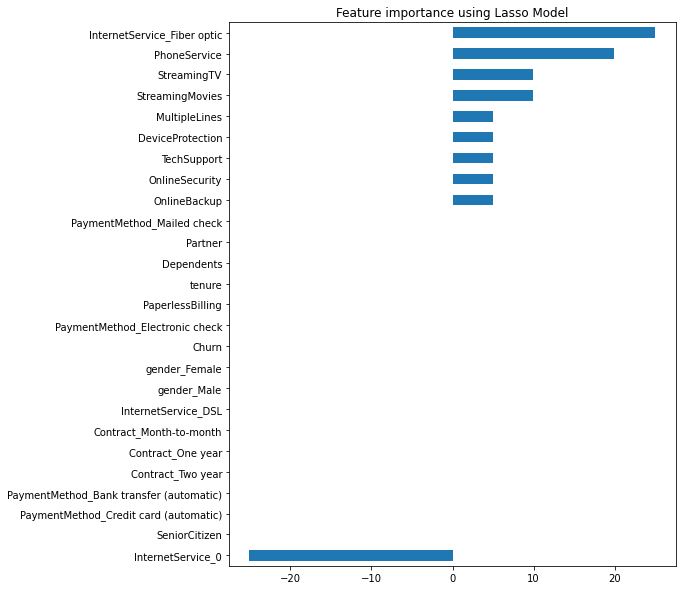

In [55]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")